# Import Tools

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense

from keras import backend as k

# Image Preprocessing

In [7]:
train_dir='/content/drive/MyDrive/github/image_classification/chest_xray/train'
test_dir='/content/drive/MyDrive/github/image_classification/chest_xray/val'
valid_dir='/content/drive/MyDrive/github/image_classification/chest_xray/test'

In [8]:
img_width=224
img_height=224
batch=8

## Preprocessing training Images

In [9]:
def get_train_generator(image_dir,target_w=img_width,target_h=img_height,seed=1,batch_size=batch):
  image_generator=ImageDataGenerator(rescale=1./255,samplewise_center=True,samplewise_std_normalization=True,zoom_range=0.2)
  generator=image_generator.flow_from_directory(image_dir,batch_size=batch_size,target_size=(target_w,target_h),class_mode='binary')
  return generator

## Preprocessing validation and test images

In [10]:
def get_test_and_valid_generator(train_image_dir,valid_image_dir,test_image_dir,target_w=img_width,target_h=img_height,batch_size=batch):
  raw_image_generator=ImageDataGenerator().flow_from_directory(train_image_dir,batch_size=batch_size,target_size=(target_w,target_h),class_mode='binary')
  # get data sample
  batch=raw_image_generator.next()
  data_sample=batch[0]

  # use sample to fit mean and std for test and validation generator
  image_generator=ImageDataGenerator(rescale=1./255,featurewise_center=True,featurewise_std_normalization=True)
  image_generator.fit(data_sample)
 
  # get valid generator
  valid_generator=image_generator.flow_from_directory(valid_image_dir,batch_size=batch_size,target_size=(target_w,target_h),class_mode='binary')
  # get test generator
  test_generator=image_generator.flow_from_directory(test_image_dir,batch_size=batch_size,target_size=(target_w,target_h),class_mode='binary')

  return valid_generator,test_generator


In [11]:

train_generator=get_train_generator(train_dir)
valid_generator,test_generator=get_test_and_valid_generator(train_dir,valid_dir,test_dir)

Found 5265 images belonging to 2 classes.
Found 5265 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Let's check a image after generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


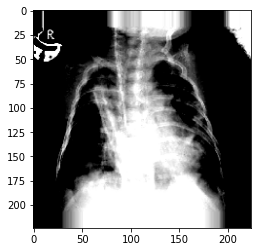

In [12]:
x,y=train_generator.__getitem__(0)
plt.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


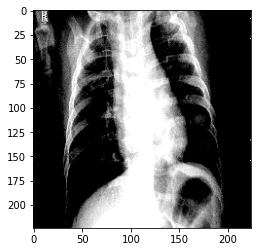

In [13]:
x,y=valid_generator.__getitem__(0)
plt.imshow(x[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


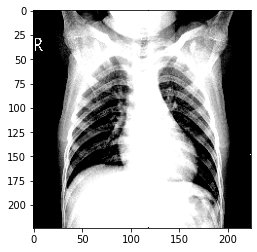

In [14]:
x,y=test_generator.__getitem__(0)
plt.imshow(x[0])

# Using an existing Model from Tensorflow hub

In [15]:
import tensorflow_hub as hub

In [17]:

model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v1_50/classification/5"),
    # Drop 20% of the neurons which contains same weight so as to avoid overfit or confusion for neurons
    tf.keras.layers.Dropout(0.2) ,
    # Final layer for Output
    Dense(units=1,activation='sigmoid')
])
# Compile model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.build([None, 224, 224, 3])

## Summary of model

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1001)              25612201  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001)              0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1)                 1002      
Total params: 25,613,203
Trainable params: 1,002
Non-trainable params: 25,612,201
_________________________________________________________________


## Creating a custom callback class

In [21]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if (logs.get('accuracy')>=0.90) & (logs.get('val_accuracy')>=0.85):
      print('\n validation accuracy already reach to 85 & Accuracy already reaches 90.\n Hence Stopping........')
      self.model.stop_training=True

In [22]:
callbacks=myCallback()

## Training Model

In [23]:

np.random.seed(32)
history=model.fit_generator(train_generator,validation_data=valid_generator,epochs=100,callbacks=[callbacks],verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
659/659 [==============================] - 1967s 3s/step - loss: 0.5015 - accuracy: 0.8211 - val_loss: 0.8414 - val_accuracy: 0.7420
Epoch 2/100
659/659 [==============================] - 116s 176ms/step - loss: 0.3234 - accuracy: 0.8750 - val_loss: 0.4354 - val_accuracy: 0.8494
Epoch 3/100
659/659 [==============================] - 116s 176ms/step - loss: 0.2908 - accuracy: 0.8895 - val_loss: 0.4705 - val_accuracy: 0.8269
Epoch 4/100
659/659 [==============================] - 115s 174ms/step - loss: 0.2588 - accuracy: 0.9041 - val_loss: 0.7529 - val_accuracy: 0.7724
Epoch 5/100
659/659 [==============================] - 115s 175ms/step - loss: 0.2844 - accuracy: 0.8942 - val_loss: 0.4223 - val_accuracy: 0.8478
Epoch 6/100
659/659 [==============================] - 115s 175ms/step - loss: 0.2591 - accuracy: 0.9014 - val_loss: 0.3187 - val_accuracy: 0.8750

 validation accuracy already reach to 85 & Accuracy already reaches 90.
 Hence Stopping........


# Visualizing the Model performance

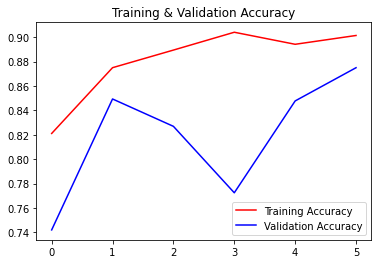

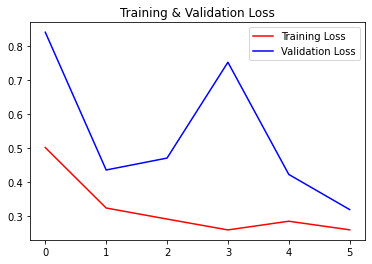

In [24]:
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
train_loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(train_acc))
plt.plot(epochs,train_acc,c='r',label='Training Accuracy')
plt.plot(epochs,val_acc,c='blue',label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend();
plt.figure()
plt.plot(epochs,train_loss,c='r',label='Training Loss')
plt.plot(epochs,val_loss,c='blue',label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend();


# Predicting the output of an image

In [36]:

from keras.preprocessing import image


In [26]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Functions for Preprocessing the test or loaded image

In [34]:
def get_mean_std_per_batch(image_path, H=img_height, W=img_width):
    sample_data = []
    for idx, img in enumerate(range(100)):
        # path = image_dir + img
        sample_data.append(
            np.array(image.load_img(image_path, target_size=(H, W))))

    mean = np.mean(sample_data[0])
    std = np.std(sample_data[0])
    return mean, std

def load_image_normalize(path, mean, std, H=img_height, W=img_width):
    x = image.load_img(path, target_size=(H, W))
    x -= mean
    x /= std
    x = np.expand_dims(x, axis=0)
    return x

def load_image(path, preprocess=True, H = img_height, W = img_width):
    """Load and preprocess image."""
    x = image.load_img(path, target_size=(H, W))
    if preprocess:
        mean, std = get_mean_std_per_batch(path, H=H, W=W)
        x -= mean
        x /= std
        x = np.expand_dims(x, axis=0)
    return x


## Finally Predicting the output

In [40]:
while True:
  path=input('Enter the file path')
  user_output=input('What is the actual output of the Image: ')
  img=load_image(path)
  model_pred=model.predict(img)
  print(model_pred[0])
  print(f'According to user the output is {user_output}')
  if model_pred[0]>0.5:
    print('Predicted output is PNEUMONIA')
  else:
    print('Predicted output is NORMAL')
  user=input('Are there any more prediction of images y or n:\n')
  if user=='y':
    continue
  else:
    break

Enter the file path/content/drive/MyDrive/github/image_classification/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
What is the actual output of the Image: Normal
[0.22089174]
According to user the output is Normal
Predicted output is NORMAL
Are there any more prediction of images y or n:
y
Enter the file path/content/drive/MyDrive/github/image_classification/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
What is the actual output of the Image: Pneumonia
[0.9998343]
According to user the output is Pneumonia
Predicted output is PNEUMONIA
Are there any more prediction of images y or n:
n
